# Does the IEKS improve the EKS solution?

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
jax.config.update('jax_enable_x64', True)
parallel = True
jax.config.update("jax_platform_name", "gpu"); parallel = False

import jax.numpy as jnp
import matplotlib.pyplot as plt
import tornadox
from tqdm import trange

from pof.solve import solve_ek, diffrax_solve, get_solver_iterator

In [4]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0, tmax=8)
ylims = (-3, 3)
dt = 1e-1
order = 3

Both the EKS and the IEKS (initialized with x0) work fine

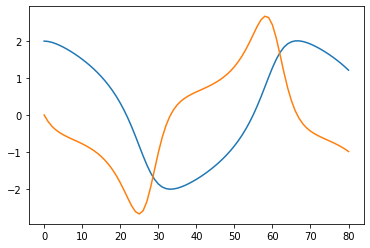

In [6]:
ts, ys_eks = solve_ek(ivp.f, ivp.y0, ivp.tmax, order=order, dt=dt)
plt.plot(ys_eks)

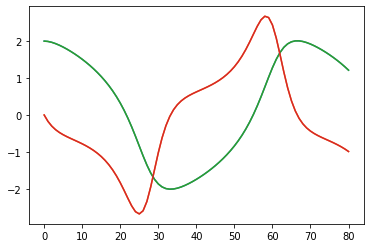

In [7]:
states, refine, project = get_solver_iterator(ivp, order=order, dt=dt, parallel=parallel)
for _ in range(20): 
    states = refine(states)
ys_ieks = project(states)

plt.plot(ys_eks)
plt.plot(ys_ieks)

But, what about the actual error? Also, can the IEKS be used to _improve_ the EKS estimate? Let's find out!

True solution with diffrax:

In [ ]:
eval_ts = jnp.arange(ivp.t0, ivp.tmax, step=dt)
true_ts, true_ys = diffrax_solve(ivp, eval_ts, rtol=1e-10, atol=1e-10)

Let's first look at the EKS & IEKS errors:

In [ ]:
plt.plot(true_ys - ys_eks, color="blue")
plt.plot(true_ys - ys_ieks, color="orange")
plt.ylim(-0.00001, 0.00001)

What if we initialize the IEKS with the EKS trajectory?

In [ ]:
_, states = solve_ek(ivp.f, ivp.y0, ivp.tmax, order=order, dt=dt, return_full_states=True)
plt.plot(true_ys - project(states))
for _ in range(20): 
    states = refine(states)
    plt.plot(true_ys - project(states))
plt.ylim(-0.00001, 0.00001)

In [ ]:
jnp.mean((true_ys - ys_eks) ** 2)

In [ ]:
jnp.mean((true_ys - project(states)) ** 2)